In [32]:
#importing modules and data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
df = pd.read_csv("./combined_forest.csv")

In [33]:
#standerdizing all values
min_max_values = df.drop(columns=['acq_date', 'fire']).agg(['min', 'max'])

for column in df.columns:
    if column not in ['acq_date', 'fire']:
        x_min = min_max_values.loc['min', column]
        x_max = min_max_values.loc['max', column]
        df[f'std_{column}'] = (df[column] - x_min) / (x_max - x_min)

print(df)

df.drop(columns=['acq_date'], inplace=True)


df.rename(columns={'DEM': 'elevation'}, inplace=True)
df.rename(columns={'std_DEM': 'std_elevation'}, inplace=True)

df.head()

      longitude   latitude    acq_date          DEM  fire    lst       prcp  \
0     81.539200  28.469100  2019-03-16   446.311615     0  24.45   0.000000   
1     84.918900  27.271500  2019-03-20   284.640900     0  27.73   0.000000   
2     84.399200  27.552000  2019-04-11   177.724487     0    NaN   0.000000   
3     84.519100  27.532800  2019-03-29   196.470398     0  28.35   0.000000   
4     82.154400  28.345800  2019-01-10  1472.567871     0  16.11   0.000000   
...         ...        ...         ...          ...   ...    ...        ...   
6316  82.139678  29.467243  2010-02-26  3198.465000     0   8.09   0.000000   
6317  82.904470  28.449312  2010-03-02  3119.710700     0  14.65   0.000000   
6318  85.212110  28.178293  2010-01-10  3761.871000     0   9.35   0.000000   
6319  82.092210  29.650521  2010-04-05  3643.557400     0  16.67   0.000000   
6320  81.856150  29.120458  2010-05-24  3002.950700     0  22.57  10.737953   

      7dayprecip         at  std_longitude  std_lat

,longitude,latitude,elevation,fire,lst,prcp,7dayprecip,at,std_longitude,std_latitude,std_elevation,std_lst,std_prcp,std_7dayprecip,std_at
0,81.5392,28.4691,446.311615,0,24.45,0.0,0.000000,20.194879,0.176930,0.557241,0.096044,0.635199,0.0,0.000000,0.729770
1,84.9189,27.2715,284.640900,0,27.73,0.0,0.000000,20.619836,0.604632,0.224464,0.061175,0.690492,0.0,0.000000,0.737811
2,84.3992,27.5520,177.724487,0,NaN,0.0,35.881322,22.968530,0.538864,0.302406,0.038115,NaN,0.0,0.279923,0.782252
3,84.5191,27.5328,196.470398,0,28.35,0.0,5.034953,22.031305,0.554037,0.297071,0.042159,0.700944,0.0,0.039279,0.764518
4,82.1544,28.3458,1472.567871,0,16.11,0.0,0.000000,10.052850,0.254784,0.522980,0.317384,0.494606,0.0,0.000000,0.537864


In [34]:
#addressing Nan values
missing_values = df.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])
#only lst has them; rasonable because lst from dataset is Nan on cloudy days

# Check how many of the null rows didnt have fires
missing_fire_0 = df[(df['fire'] == 0) & df.isnull().any(axis=1)].shape[0]
print(f"Number of rows with 'fire' as 0 and missing values: {missing_fire_0}")


# Drop rows with missing values as they are mostly where fires didnt happen
df_cleaned = df.dropna()

# Display the shape of the cleaned DataFrame
print("Shape of the cleaned DataFrame:", df_cleaned.shape)

column_names = df_cleaned.columns.tolist()
print("Column Names:")
print(column_names)

Columns with missing values:
lst        1220
std_lst    1220
dtype: int64
Number of rows with 'fire' as 0 and missing values: 1044
Shape of the cleaned DataFrame: (5101, 15)
Column Names:
['longitude', 'latitude', 'elevation', 'fire', 'lst', 'prcp', '7dayprecip', 'at', 'std_longitude', 'std_latitude', 'std_elevation', 'std_lst', 'std_prcp', 'std_7dayprecip', 'std_at']


In [35]:
X = df_cleaned[['std_longitude', 'std_latitude', 'std_elevation', 'std_lst', 'std_prcp', 'std_7dayprecip', 'std_at']]
y = df_cleaned['fire']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

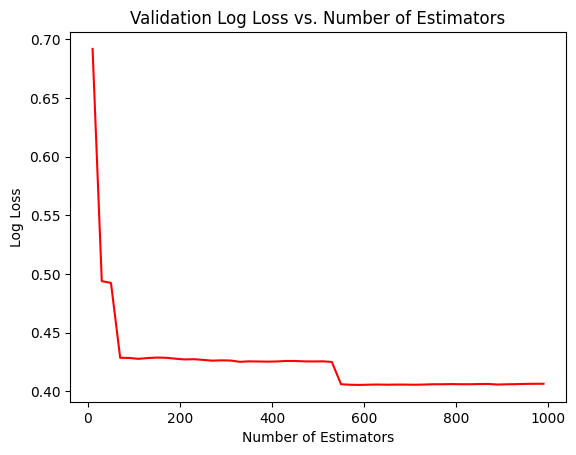

Best number of estimators: 590


In [36]:
#calculate the best number of estimators

# Initialize an empty list to store errors
errors = []

# Create a growing RandomForestClassifier
growing_rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, warm_start=True, random_state=1514)

# Iterate over a range of values for n_estimators
for n_estimators in range(10, 1010, 20):
    growing_rf.set_params(n_estimators=n_estimators)  # Update n_estimators using set_params
    growing_rf.fit(X_train, y_train)
    errors.append(log_loss(y_valid, growing_rf.predict_proba(X_valid)))

# Plot the errors
plt.plot(range(10, 1010, 20), errors, '-r')
plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.title('Validation Log Loss vs. Number of Estimators')
plt.show()

# Find the best number of estimators with the lowest log loss
best_n_estimators = np.argmin(errors) * 20 + 10
print("Best number of estimators:", best_n_estimators)

In [37]:
#training the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier with the best number of estimators
rf_classifier = RandomForestClassifier(n_estimators=590, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.82
Confusion Matrix:
[[917 112]
 [166 336]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1029
           1       0.75      0.67      0.71       502

    accuracy                           0.82      1531
   macro avg       0.80      0.78      0.79      1531
weighted avg       0.82      0.82      0.82      1531



In [38]:
# Use the trained Random Forest classifier to make predictions for the entire dataset
df_cleaned['forest_loss_prediction'] = rf_classifier.predict(X)

print(df_cleaned.head())

area_to_predict = df_cleaned[['std_longitude', 'std_latitude', 'std_elevation', 'std_lst', 'std_prcp', 'std_7dayprecip', 'std_at']]
fire_probabilities = rf_classifier.predict_proba(area_to_predict)[:, 1]

df_cleaned['fire_prediction'] = fire_probabilities

#only keeping the long lat and predicitons
df_cleaned = df_cleaned[['longitude', 'latitude', 'forest_loss_prediction']]



df_cleaned.to_csv('./forestpred.csv', index=False)

   longitude  latitude    elevation  fire    lst       prcp  7dayprecip  \
0    81.5392   28.4691   446.311615     0  24.45   0.000000    0.000000   
1    84.9189   27.2715   284.640900     0  27.73   0.000000    0.000000   
3    84.5191   27.5328   196.470398     0  28.35   0.000000    5.034953   
4    82.1544   28.3458  1472.567871     0  16.11   0.000000    0.000000   
5    82.8061   27.9133   419.713501     0  37.89  12.236837    0.000000   

          at  std_longitude  std_latitude  std_elevation   std_lst  std_prcp  \
0  20.194879       0.176930      0.557241       0.096044  0.635199  0.000000   
1  20.619836       0.604632      0.224464       0.061175  0.690492  0.000000   
3  22.031305       0.554037      0.297071       0.042159  0.700944  0.000000   
4  10.052850       0.254784      0.522980       0.317384  0.494606  0.000000   
5  26.071588       0.337256      0.402801       0.090307  0.861767  0.118581   

   std_7dayprecip    std_at  forest_loss_prediction  
0        0.000

/tmp/ipykernel_23888/3544183308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['forest_loss_prediction'] = rf_classifier.predict(X)
/tmp/ipykernel_23888/3544183308.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['fire_prediction'] = fire_probabilities
